In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.SHIPS_preprocess import calc_d24_VMAX, fore_hr_averaging, load_processed_SHIPS
from utils import SHIPS_ML_model_funcs
from utils.SHIPS_ML_model_funcs import get_train_test_split, SHIPS_train_test_shuffle_CLASS, SHIPS_train_test_split
from utils import SHIPS_plotting
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score, precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
import matplotlib.colors


##### Ignore Annoying Warnings

In [3]:
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action="ignore",category=ConvergenceWarning)

### Model Parameters

##### SHIPS Dataset Choice
* max_fore: maximum forecast hours [usually 24 or 48]
* mask_TYPE: how are we handling cases close to land? [SIMPLE_MASK or no_MASK]
* interp_str: Did we interpolate over missing data or not? [INTERP: yes, no_INTERP: no]
* yr_start:  First year of training data [2010 or 2005, generally]
* yr_end_LOAD:  Last year of full data (to find file)[2021]
* yr_end_TRAIN: Last year to use in training [2018 is default]
* use_basin:  Default is to use all basins, but if we just want to use one basin, we can specify that here [ATLANTIC, EAST_PACIFIC, WEST_PACIFIC, and SOUTHERN_HEM are the choices]

In [4]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_end_LOAD = 2021 # for loading data
yr_end_TRAIN = 2018
use_basin = 'ALL'

#### SHIPS analysis choices
* `hrs_max`: maximum forecast hours (usually 24; should be same or less than `max_fore`)
* `RI_thresh`: change in wind speed over `hrs_max` needed for RI; default threshold is `30` kt increase in wind speed in `24` hours
* `is_RI_only`: flag for future instances of a multi-class classification problem (should always be set to `True` for now)
* `n_classes`: related to `is_RI_only`; how many classes are we classifying into (should be `2` for now)
* `is_standard`: flag to indicate whether or not we want to do feature scaling with `StandardScaler` (default is `True`)
* `DO_AVG`: flag to indicate whether or not we are averaging over our forecast period or treating each 6-hrly forecast as a separate predictor (default is `True`)
* `drop_features`: list of features to drop before model training (usually needed for preprocessing but we don't want to train the model on them).  Commonly dropped features include:
    * `TYPE`: storm type; should be 1 everywhere (tropical cyclones only)
    * `VMAX`: maximum surface winds; we define our classes based entirely on `VMAX` so we don't want it in our features
    * `DELV`: we only use `DELV -12` (change in wind speeds from -12 h to 0 h) and not the change in wind speeds relative to 0 for all hours
    * `VMPI`: we calculated `POT` (basically `VMPI` - `VMAX_0`) so we don't need to also include `VMPI`
    * `is_TRAIN`: just a flag we use to separate training data from validation in our bootstrapped experiments; not an actual feature to train on 
* `to_IND`: list of quantities we want to index on for our multi-index (note that these quantities will NOT be considered features)
    * `BASIN`: ocean basin
    * `CASE`: case number
    * `NAME`: name of tropical cyclone
    * `DATE_full`: date of case (YYYY-MM-DD-HH:MM:SS).  Time stamp is for `time 0`
    * `TIME`: forecast time.  should range from `0` to `max_fore_hrs`

In [5]:
hrs_max = 24
drop_features = {'TYPE','VMAX','DELV','VMPI','is_TRAIN'}
to_IND = ['BASIN','CASE','NAME','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True

##### Load our pre-processed SHIPS files

In [6]:
SHIPS_predictors,BASIN = load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)

#### ML Model Hyperparameters.  This will change based on the type of model
* <code>Solver</code>:  For logistic regression models, we have a few choices of solver. We will stick only with solvers that can handle multi-class classification, as we want to be able to compare different formulations of this problem. We have a few options:
 * The default solver, <code>'lbfgs'</code>, (stands for Limited-memory Broyden-Fletcher-Goldfarb-Shanno).  Approximates second derivative with gradient evaluations; only stores last few updates, so saves memory.  Not super fast.
 * <code>sag</code>: stands for "stochastic average gradient".  A version of gradient descent.  Fast for big datasets. 
 * <code>saga</code>: a version of <code>sag</code> that allows for <code>L1</code> regularizaiton. 
* <code> Penalty</code>: Are we regularizing using the L1 norm (absolute-value based) or the L2 norm (least-squares based)? For <code>sag</code> and <code>lbfgs</code>, we will use the <code>L2</code> penalty; for <code>saga</code> we will use <code>L1</code>. 
* <code>k_folds</code>: number of folds used in our cross-validation approach.  We will use a <code>Stratified K-Means cross-validation</code> since we have imbalanced classes. 
* `C_vals`: $C$ is the model's regularization parameter.  We'll explore different values of $C$ in our hyperparameter sweep.  $C$ is the main hyperparameter that we can use to tune the model
* `max_iter`: maximum number of iterations

In [7]:
solver = 'sag'
k_folds = 10
n_repeats = 3
# Use L1 penalty for SAGA, use L2 for others.
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'
# We are predicting our model class (RI (1) or not-RI (0))
to_predict = 'I_class'
# Model hyperparameters
C_vals = np.logspace(-2,2,5)  #normalization factor
max_iter = np.logspace(2,4,3) #max iterations

##### Class weighting
This part is tricky but important.  Since we are really interested in rapid intensification, which is by definition, rare, we will inherently be creating imbalanced classes for our data.  We can address this in many ways.  Broadly, we can either use <b>class weights</b> (which apply different weights to each data point based on which class it is in), or we can use under/over sampling.  <b>Undersampling</b> means we will sample the minority class at a rate that is commeasurate with the majority class--we lose information, but are less likely to overfit to our minority class.  <b>Oversampling</b> means we will draw additional samples from our minority class to match the size of our majority class.  

We explored a few different options for this (see exploratory sampling notebook) and ultimately found that class weights work just fine, so generally we just use the default class weighting scheme, `balanced`, which adjusts weights automatically to make them inversely proportional to class size. 

If we want to use custom weights, we can turn on `use_custom_wts` and specify them.  If we don't want to use weights (not a good choice for imbalanced classes but w/e), we can set `no_wts` to `True`.  If both `use_custom_wts` and `no_wts` are `False`, we'll use the default weights (`balanced`). 

In [8]:
# Weights
use_custom_wts = False 
no_wts = False

##### Calculate class weights, if desired

In [9]:
# Custom weights
if use_custom_wts:
    # I think this function has a bug, DO NOT USE (7/6/22)
   #  class_wts = SHIPS_preprocess.calculate_class_weights(SHIPS_predictors,n_classes,RI_thresh,0)
    # weights_use = class_wts.xs(use_basin)
   #  wts_sel = weights_use['WEIGHT'].to_dict()
    wts_str = 'custom_wts'
    wts_sel = np.nan
# No weighting
elif no_wts:
    wts_sel = 0
    wts_str = 'none'
# Default sklearn class weights (balanced)
else:
    wts_sel = 0
    wts_str = 'default_wts'

#### Bootstrapping!! 

First, initialize some dataframes for results

In [10]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()

###### Bootstrapping parameters:

* `N_samples`: number of experiments
* `ncats`: number of categories for classification (default is 2)
* `scoring`: scoring function for ML model (we typically used `f1_weighted` as it's better for imbalanced classes)
* `n_valid`: number of years to use for validation

###### Overview
1. Of full training period (2005-2018), we randomly select `n_valid` years to use for validation.  We use a modified leave-one-year-out approach (where instead we leave `n_valid` years out. This step is handled by the `get_train_test_split` function.  Thus we divide our SHIPS predictors as well as our target variable into training and validation samples based on year. 
2. We set up a hyperparameter sweep using `sklearn`'s `gridsearchCV` (contained in `create_gridsearch_LR` function).  For logistic regression, we only have one main hyperparameter--the normalization factor, $C$; we identifed values of $C$ in `C_vals` previously. 
3. After identifying best hyperparameters, we train (`model.fit()`).  We train once on cases from all ocean basins.
4. Once training is complete, we try to predict class of our validation years.  We predict each ocean basin separately, as well as predict all ocean basins combined. We use `get_scores_best_params_LR` to get the hyperparameters for our best model, `get_confusion_matrix_LR` to get the confusion matrix and contingency table stats for our model, `get_feature_importances_LR` to get the feature importances, and `get_roc_AUC` to get the receiver operator curve (ROC) and area under the curve (AUC). 
5. We save all of the output and repeat the process, selecting new validation years and fully re-training every time until we have done `N_samples` experiments. 

In [11]:
N_samples = 15
ncats = 2
scoring = 'f1_weighted'
cut = 'equal'
FULL_yrs = np.arange(yr_start,yr_end_TRAIN,1)
n_valid = 3 # number of years to leave out for validation

for i in np.arange(0,N_samples):
# i = 0
    print('running sample ',i)
    # Split data into training/validation 
    test_years = np.random.choice(FULL_yrs,n_valid,replace=False) # years we will use for validation
    X_train, X_test, y_train, y_test, feature_names, diff_train, diff_test = SHIPS_ML_model_funcs.get_train_test_split(test_years,SHIPS_predictors,to_predict,
                                                                    is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)
    #
    # Set up hyperparameter sweep
    LR_model = SHIPS_ML_model_funcs.create_gridsearch_LR(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,
                                    use_custom_wts,wts_sel,scoring,no_wts)

    # Fit model using training data.  We only train once, on cases from all 4 basins
    print('fitting model')
    LR_model.fit(X_train,y_train['I_class'])


   # 
    BASIN_all = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTHERN_HEM','ALL']
    print('calculating scores')
    # Now, perform validation.  We'll analyze each basin separately as well as a combined score for all basins. 
    for basin in BASIN_all:
        #basin = 'ATLANTIC'
        print('running ',basin)
        report, y_true, y_pred = SHIPS_ML_model_funcs.get_scores_best_params_LR(LR_model,X_test,y_test,basin)
        report['Years Out'] = str(test_years)
        report['Model'] = solver
        report['Fold'] = i
        label_names = ['not RI','RI']

        #
        cm_stats = SHIPS_ML_model_funcs.get_confusion_matrix_LR(LR_model,y_true,y_pred,basin,label_names,ncats)
        cm_stats['Years Out'] = str(test_years)
        cm_stats['Model'] = solver
        cm_stats['Fold'] = i
        #
        fi_pred = SHIPS_ML_model_funcs.get_feature_importances_LR(LR_model,X_test,y_test,basin,scoring)
        fi_pred['Years Out'] = str(test_years)
        fi_pred['Fold'] = i
        fi_pred['Model'] = solver
        #
        fi_pred_train = SHIPS_ML_model_funcs.get_feature_importances_LR(LR_model,X_train,y_train,basin,scoring)
        fi_pred_train['Years Out'] = str(test_years)
        fi_pred_train['Fold'] = i
        fi_pred_train['Model'] = solver
        #
        ypred_prob, p_vs_r, roc_vals = SHIPS_ML_model_funcs.get_roc_auc(X_test,basin,LR_model,y_test,1,'RI',scoring,cut)

        #
        p_vs_r['Fold'] = i
        p_vs_r['Years Out'] = str(test_years)
        p_vs_r['Model'] = solver
        roc_vals['Fold'] = i
        roc_vals['Model'] = solver
        roc_vals['Years Out'] = str(test_years)
        #
        if basin != 'ALL':
            y_pred_all = y_test.xs(basin).copy()
        else:
            y_pred_all = y_test.copy()
        y_pred_all['Y pred'] = y_pred
        y_pred_all['Predicted Basin'] = basin
        y_pred_all['Model'] = solver
        y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
        y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
        #
        predicted_y_ALL = predicted_y_ALL.append(y_pred_all.reset_index())
        roc_vals_ALL = roc_vals_ALL.append(roc_vals)
        p_vs_r_ALL = p_vs_r_ALL.append(p_vs_r)
        fi_pred_ALL = fi_pred_ALL.append(fi_pred)
        fi_pred_train_ALL = fi_pred_train_ALL.append(fi_pred_train)
        cm_ALL = cm_ALL.append(cm_stats)
        report_ALL = report_ALL.append(report)

running sample  0
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC
running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL
running sample  1
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  2
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  3
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  4
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  5
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  6
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM
running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  7
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  8
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  9
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL
running sample  10
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  11
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC
running  WEST_PACIFIC
running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  12
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  13
averaging hours together
fitting model
calculating scores
running  ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  WEST_PACIFIC
running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running sample  14
averaging hours together
fitting model
calculating scores
running  ATLANTIC
running  EAST_PACIFIC
running  WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


running  ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:397: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


In [12]:
LR_model.predict_proba(X_test)

array([[0.46923456, 0.53076544],
       [0.09900299, 0.90099701],
       [0.17879072, 0.82120928],
       ...,
       [0.96069245, 0.03930755],
       [0.15748687, 0.84251313],
       [0.30001663, 0.69998337]])

In [13]:
#predicted_y_ALL = predicted_y_ALL.drop(columns={'BASIN'})
predicted_y_ALL['BASIN'] = predicted_y_ALL['Predicted Basin']

<AxesSubplot:xlabel='BASIN', ylabel='1.0'>

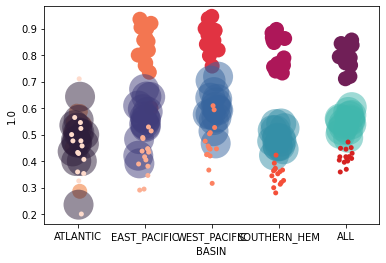

In [14]:
foo = report_ALL.reset_index().rename(columns={'index':'Score'})
foo2 = foo.set_index(['Score'])
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='1.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='1.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='1.0',palette=sns.color_palette('Reds'),s=5)


In [15]:
foo2#.xs('Recall').groupby(['BASIN']).max()

,0.0,1.0,accuracy,macro avg,weighted avg,BASIN,C,Max Iter,Years Out,Model,Fold
Score,,,,,,,,,,,
precision,0.916084,0.325000,0.786885,0.620542,0.835335,ATLANTIC,10.0,1000.0,[2006 2011 2014],sag,0
recall,0.829114,0.520000,0.786885,0.674557,0.786885,ATLANTIC,10.0,1000.0,[2006 2011 2014],sag,0
f1-score,0.870432,0.400000,0.786885,0.635216,0.806165,ATLANTIC,10.0,1000.0,[2006 2011 2014],sag,0
support,158.000000,25.000000,0.786885,183.000000,183.000000,ATLANTIC,10.0,1000.0,[2006 2011 2014],sag,0
precision,0.943396,0.513761,0.768657,0.728579,0.839194,EAST_PACIFIC,10.0,1000.0,[2006 2011 2014],sag,0
...,...,...,...,...,...,...,...,...,...,...,...
support,293.000000,68.000000,0.684211,361.000000,361.000000,SOUTHERN_HEM,0.1,1000.0,[2009 2007 2010],sag,14
precision,0.887168,0.450704,0.675399,0.668936,0.766370,ALL,0.1,1000.0,[2009 2007 2010],sag,14
recall,0.631496,0.790123,0.675399,0.710810,0.675399,ALL,0.1,1000.0,[2009 2007 2010],sag,14


<AxesSubplot:xlabel='BASIN', ylabel='0.0'>

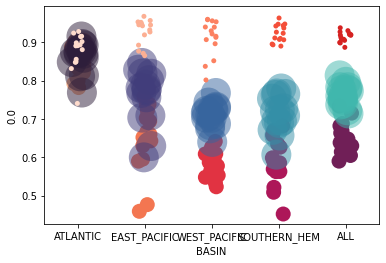

In [16]:
sns.stripplot(data=foo2.xs('recall'),x='BASIN',y='0.0',palette=sns.color_palette('rocket_r'),s=15)
sns.stripplot(data=foo2.xs('f1-score'),x='BASIN',y='0.0',palette=sns.color_palette('mako'),s=30,alpha=0.5)
sns.stripplot(data=foo2.xs('precision'),x='BASIN',y='0.0',palette=sns.color_palette('Reds'),s=5)


Get directory and filenames for saving

In [17]:
save_dir = 'DATA/ML_model_results/TRAINING/'
model_type = 'LOGISTIC'
save_dir = save_dir+model_type+'/'
save_extension = 'TRAIN_{solver}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{N}_samples_{scoring}.csv'.format(solver=solver,yr_start=yr_start,yr_end=yr_end_TRAIN,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N=N_samples,scoring=scoring)
save_ext_figs = 'TRAIN_{solver}_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'weights_{wts_str}_{N}_samples_{scoring}.png'.format(solver=solver,yr_start=yr_start,yr_end=yr_end_TRAIN,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,wts_str=wts_str,N=N_samples,scoring=scoring)

In [18]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
fi_pred_ALL.to_csv(save_dir+'Feat_Imp_validation'+save_extension)
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)

#### Make some basic plots for this LR model

###### Precision vs Recall plots

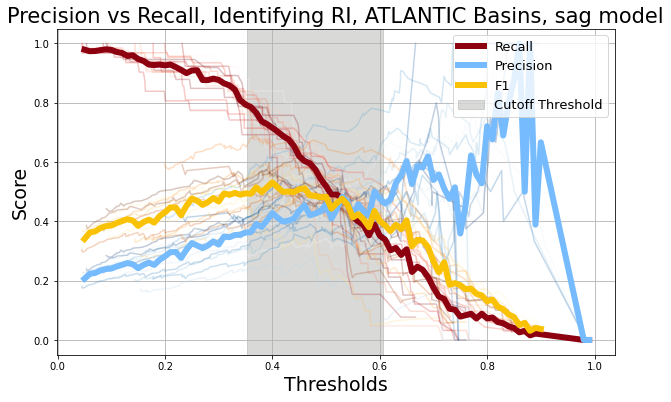

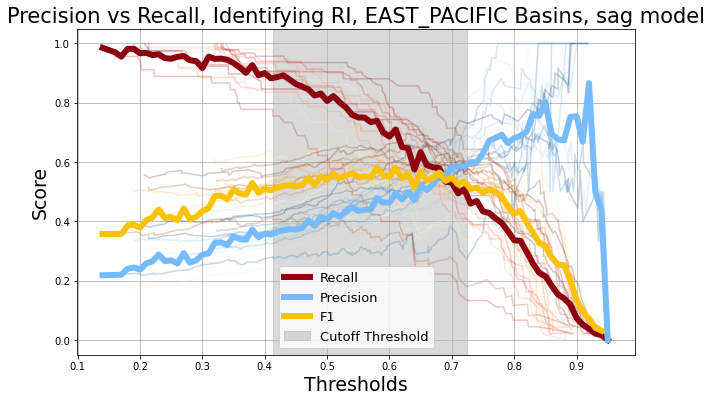

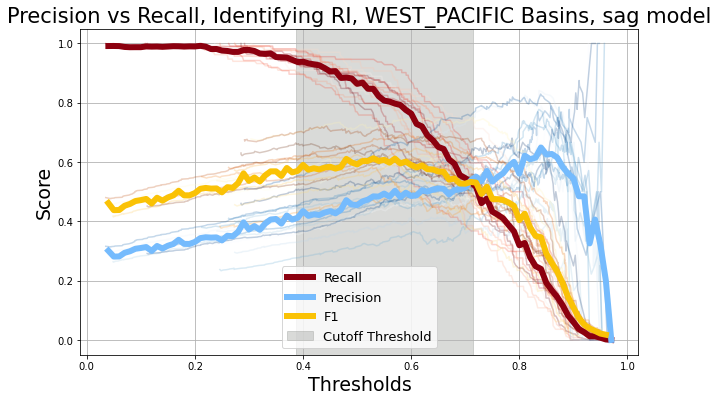

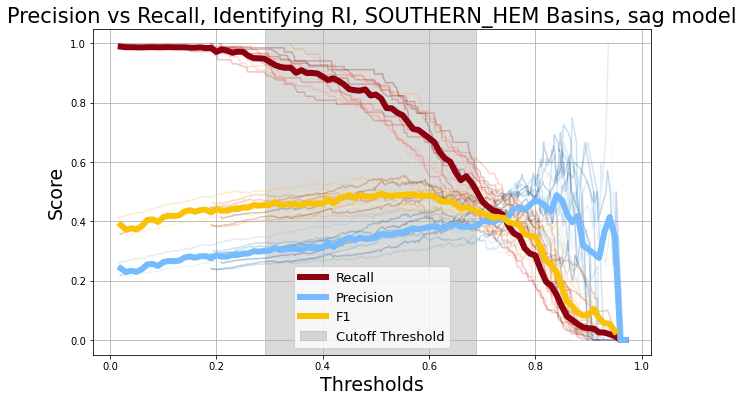

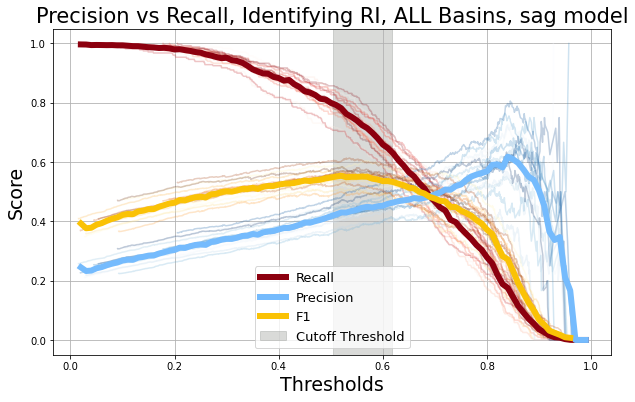

In [19]:
p_vs_r_ALL_plt = p_vs_r_ALL.reset_index()#.iloc[::2]
#basin_sel = 'ALL'

for basin_sel in BASIN_all:
    foo = p_vs_r_ALL_plt.set_index(['BASIN']).loc[basin_sel].drop(columns={'index'})
    foo2 = foo.copy()
    foo2['Thresholds Round'] = foo2['Thresholds'].round(2)
    means_plt = foo2.groupby(['Thresholds Round']).mean().reset_index()
    fig1,ax1 = plt.subplots(1,1,figsize=(10,6))
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Recall',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'Reds')
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='Precision',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'Blues')
    sns.lineplot(data=foo2.reset_index(),x='Thresholds',y='F1',hue='Fold',ax=ax1,alpha=0.25,legend=None,
                palette = 'YlOrBr')
    thresh_min = foo2.reset_index()['Cutoff Threshold'].min()
    thresh_max = foo2.reset_index()['Cutoff Threshold'].max()

    ax1.axvspan(thresh_min,thresh_max,alpha=0.35,color='xkcd:gray',label='Cutoff Threshold')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Recall',ax=ax1,linewidth=6,color='xkcd:crimson',label='Recall')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='Precision',ax=ax1,linewidth=6,color='xkcd:sky blue',label='Precision')
    sns.lineplot(data=means_plt,x='Thresholds Round',y='F1',ax=ax1,linewidth=6,color='xkcd:goldenrod',label='F1')
    ax1.set_xlabel('Thresholds',fontsize=19)
    ax1.set_ylabel('Score',fontsize=19)
    ax1.legend(fontsize=13)
    ax1.grid()
    ax1.set_title('Precision vs Recall, Identifying RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                                                           solver=solver),fontsize=21)
    fig1.savefig(save_dir+'figs/P_vs_R_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,format='png',
                 dpi=250,bbox_inches='tight')

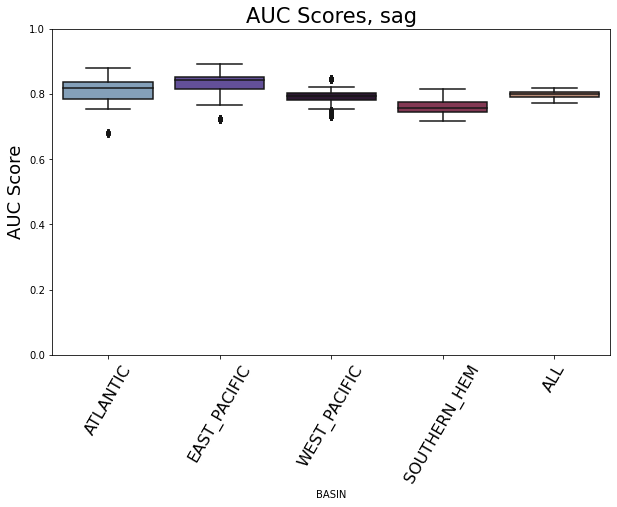

In [20]:
fig3,ax3 = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=roc_vals_ALL,x='BASIN',y='AUC ROC Score',ax=ax3,palette='twilight')
ax3.set_ylim([0,1])
ax3.set_xticklabels(roc_vals_ALL['BASIN'].unique(),fontsize=16,rotation=60)
ax3.set_ylabel('AUC Score',fontsize=18)
ax3.set_title('AUC Scores, {solver}'.format(solver=solver),fontsize=21)
fig3.savefig(save_dir+'figs/AUC_scores_all_basins_{solver}'.format(solver=solver)+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

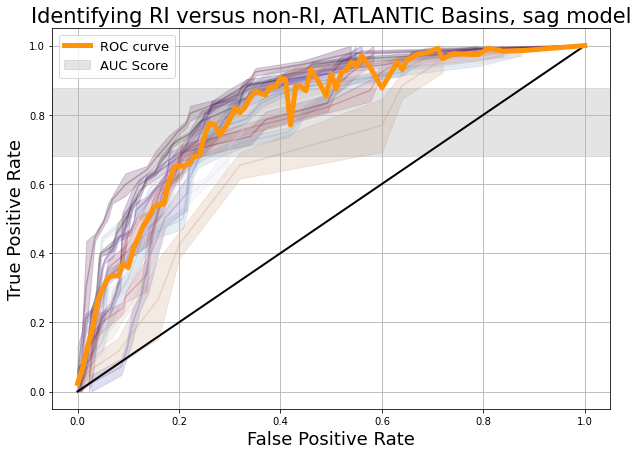

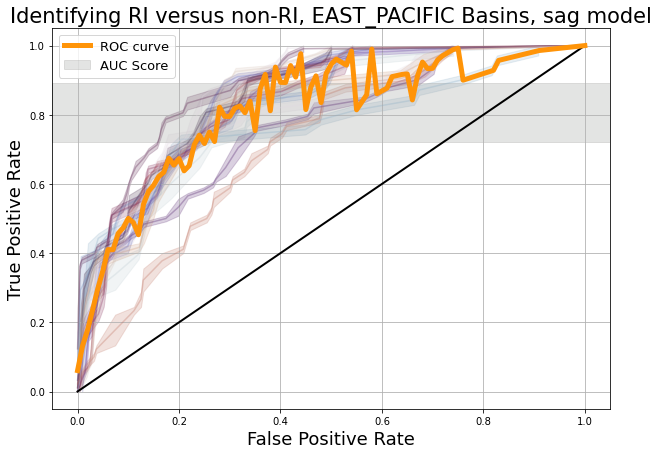

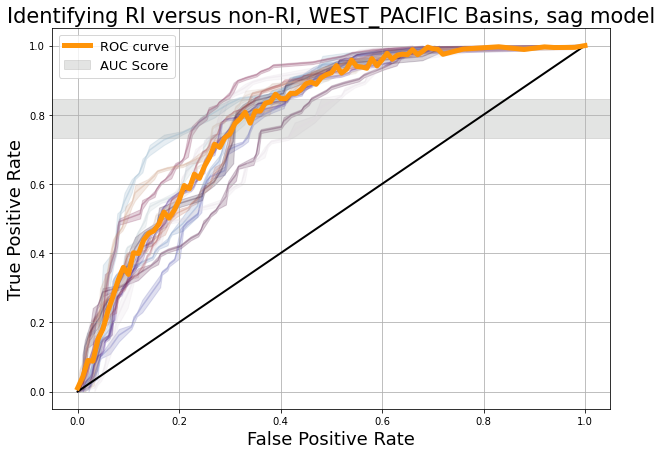

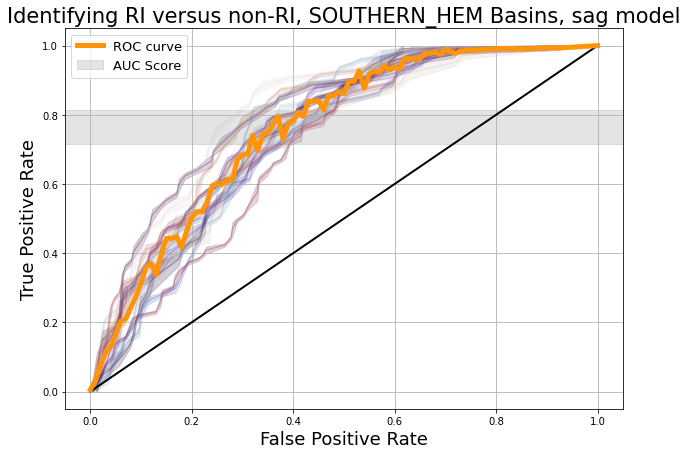

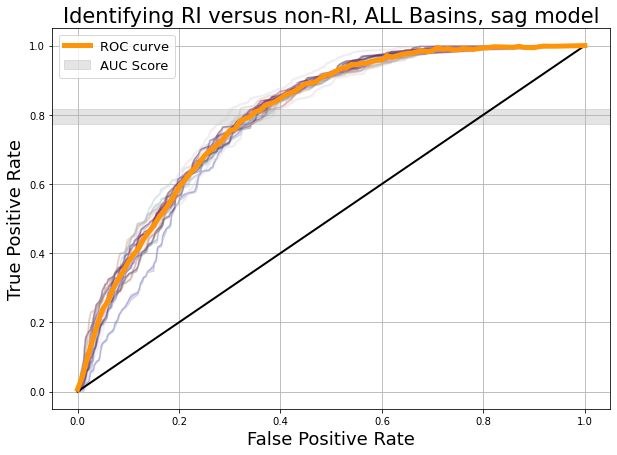

In [21]:
for basin_sel in BASIN_all:
    fig2,ax2 = plt.subplots(1,1,figsize=(10,7))
    roc_vals_plt = roc_vals_ALL.set_index(['BASIN']).xs(basin_sel).reset_index()
    roc_min = roc_vals_plt['AUC ROC Score'].min()
    roc_max = roc_vals_plt['AUC ROC Score'].max()

    sns.lineplot(data=roc_vals_plt,x='False Positive Rate',y='True Positive Rate',hue='Fold',ax=ax2,legend=False,
                alpha=0.3,palette='twilight')
    ax2.plot([0,1],[0,1],color='k',linewidth=2)
    ax2.axhspan(roc_min,roc_max,color='xkcd:gray',alpha=0.25,label='AUC Score')
    ax2.set_xlabel('False Positive Rate',fontsize=18)
    ax2.set_ylabel('True Positive Rate',fontsize=18)
    roc_vals_mean = roc_vals_plt.groupby(roc_vals_plt['False Positive Rate'].round(2))[['True Positive Rate',
                                    'AUC Thresholds']].mean().reset_index()
    roc_vals_mean.plot(x='False Positive Rate',y='True Positive Rate',ax=ax2,color='xkcd:tangerine',linewidth=5,
                      label='ROC curve')
    ax2.legend(fontsize=13)
    ax2.grid()
    ax2.set_title('Identifying RI versus non-RI, {basin_sel} Basins, {solver} model'.format(basin_sel=basin_sel,
                                                                                           solver=solver),fontsize=21)
    f2_save = save_dir+'figs/ROC_curve_{basin_sel}'.format(basin_sel=basin_sel)
    fig2.savefig(f2_save+save_ext_figs,format='png',
                 dpi=250,bbox_inches='tight')

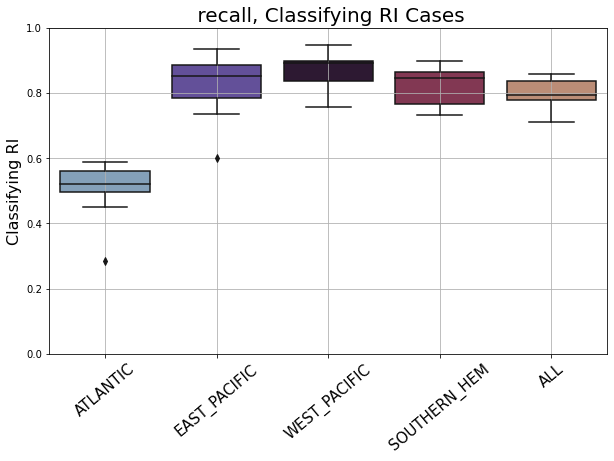

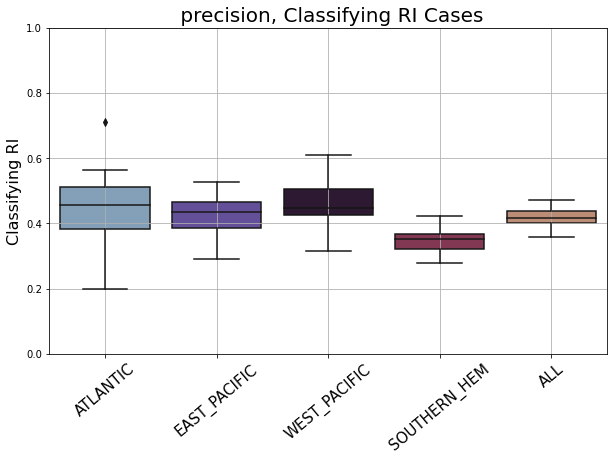

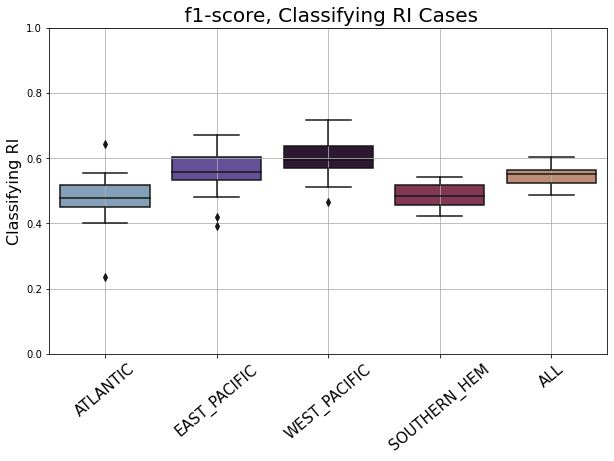

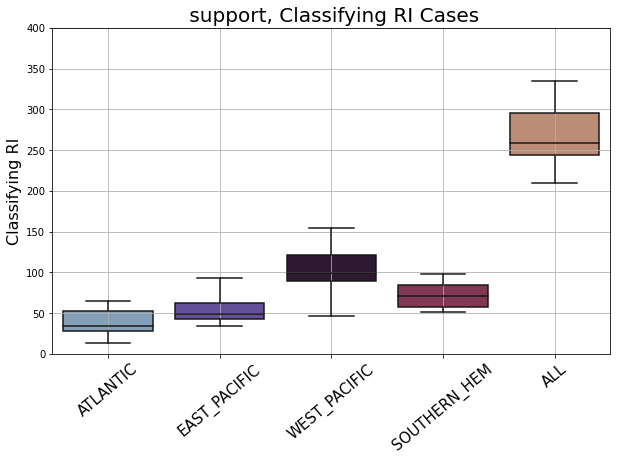

In [22]:
report_plot = report_ALL.reset_index().rename(columns={'index':'Scores','0.0':'not RI','1.0':'RI'})
report_plt_all = report_plot.set_index(['Scores','BASIN','Fold'])
score_sel_ALL = ['recall','precision','f1-score','support']
for score_sel in score_sel_ALL:
    report_plt_mean = report_plt_all.xs((score_sel)).reset_index()
    fig4,ax4 = plt.subplots(1,1,figsize=(10,6))
    sns.boxplot(data=report_plt_mean,x='BASIN',y='RI',ax=ax4,palette='twilight')
    if score_sel == 'support':
        ax4.set_ylim([0,400])
    else:
        ax4.set_ylim([0,1])
    ax4.set_ylabel('Classifying RI',fontsize=16)
    ax4.set_xlabel(None)
    ax4.set_xticklabels(report_plt_mean['BASIN'].unique(),fontsize=15,rotation=40)
    ax4.grid()
    ax4.set_title(' {score_sel}, Classifying RI Cases'.format(score_sel=score_sel),fontsize=20)
    fig4.savefig(save_dir+'figs/{score_sel}_all_samples_RI_cases'.format(score_sel=score_sel)+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')
    

/tmp/ipykernel_3577185/2732640965.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
/tmp/ipykernel_3577185/2732640965.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)


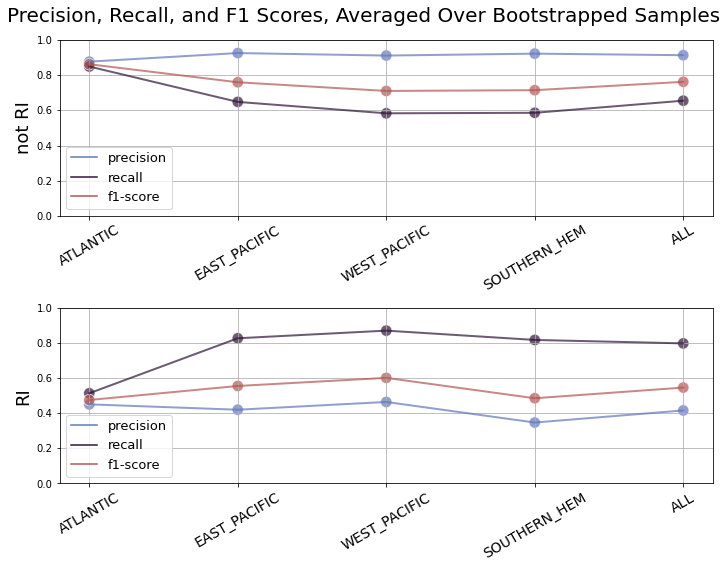

In [23]:
report_plt2 = report_plt_all.loc[['precision','recall','f1-score']].mean(level=(0,1)).reset_index()
fig5,(ax5a,ax5b) = plt.subplots(2,1,figsize=(10,8))
sns.scatterplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',s=130,ax=ax5a,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='not RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5a,alpha=0.7)

sns.scatterplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',s=130,ax=ax5b,alpha=0.7,legend=False)
sns.lineplot(data=report_plt2,x='BASIN',y='RI',hue='Scores',palette='twilight',linewidth=2,ax=ax5b,alpha=0.7)

ax5a.set_ylim([0,1])
ax5b.set_ylim([0,1])
ax5a.set_ylabel('not RI',fontsize=18)
ax5b.set_ylabel('RI',fontsize=18)
ax5a.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5a.set_xlabel(None)
ax5b.set_xticklabels(report_plt2['BASIN'].unique(),fontsize=14,rotation=30)
ax5b.set_xlabel(None)
ax5a.grid()
ax5b.grid()
ax5a.legend(fontsize=13)
ax5b.legend(fontsize=13)
fig5.suptitle('Precision, Recall, and F1 Scores, Averaged Over Bootstrapped Samples',fontsize=20)
fig5.tight_layout()
fig5.savefig(save_dir+'figs/Scores_averaged_RI_non_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')


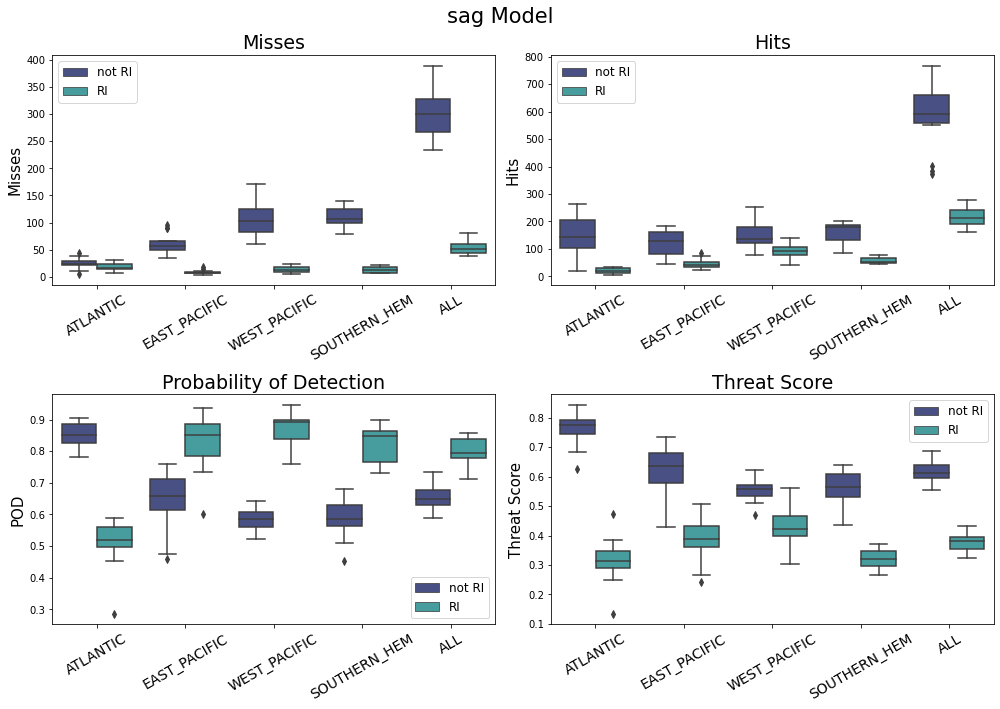

In [24]:
#sns.heatmap(data=cm_ALL,x='Category',y='Misses')
#cm_ALL['BIAS'] = (cm_ALL['Hits']+cm_ALL['False Alarms'])/(cm_ALL['Hits'] + cm_ALL['Misses'])

fig6,((ax6a,ax6b),(ax6c,ax6d)) = plt.subplots(2,2,figsize=(14,10))
sns.boxplot(data=cm_ALL,x='BASIN',y='Misses',hue='Category Names',palette='mako',ax=ax6a)
ax6a.set_ylabel('Misses',fontsize=15)
ax6a.legend(fontsize=12)
ax6a.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6a.set_title('Misses',fontsize=19)
ax6a.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Hits',hue='Category Names',palette='mako',ax=ax6b)
ax6b.set_ylabel('Hits',fontsize=15)
ax6b.legend(fontsize=12)
ax6b.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6b.set_title('Hits',fontsize=19)
ax6b.set_xlabel(None)
#
sns.boxplot(data=cm_ALL,x='BASIN',y='POD',hue='Category Names',palette='mako',ax=ax6c)
ax6c.set_ylabel('POD',fontsize=15)
ax6c.legend(fontsize=12)
ax6c.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6c.set_title('Probability of Detection',fontsize=19)
ax6c.set_xlabel(None)
#
#
sns.boxplot(data=cm_ALL,x='BASIN',y='Threat',hue='Category Names',palette='mako',ax=ax6d)
ax6d.set_ylabel('Threat Score',fontsize=15)
ax6d.legend(fontsize=12)
ax6d.set_xticklabels(cm_ALL['BASIN'].unique(),fontsize=14,rotation=30)
ax6d.set_title('Threat Score',fontsize=19)
ax6d.set_xlabel(None)
#

fig6.suptitle('{solver} Model'.format(solver=solver),fontsize=21)
fig6.tight_layout()
fig6.savefig(save_dir+'figs/CM_results_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

In [25]:
# fi_plt_plt

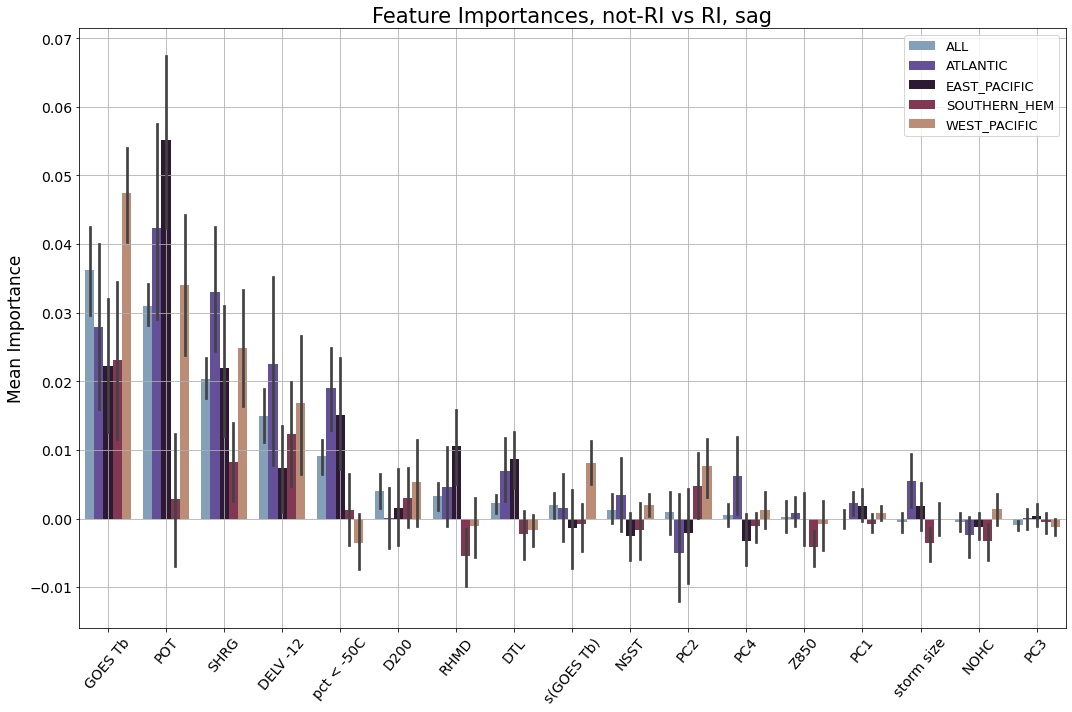

In [26]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.tick_params(axis='y',labelsize=14)
ax7.grid()
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, not-RI vs RI, {solver}'.format(solver=solver),fontsize=21)
fig7.tight_layout()
fig7.savefig(save_dir+'figs/Feat_Imp_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Each basin separately

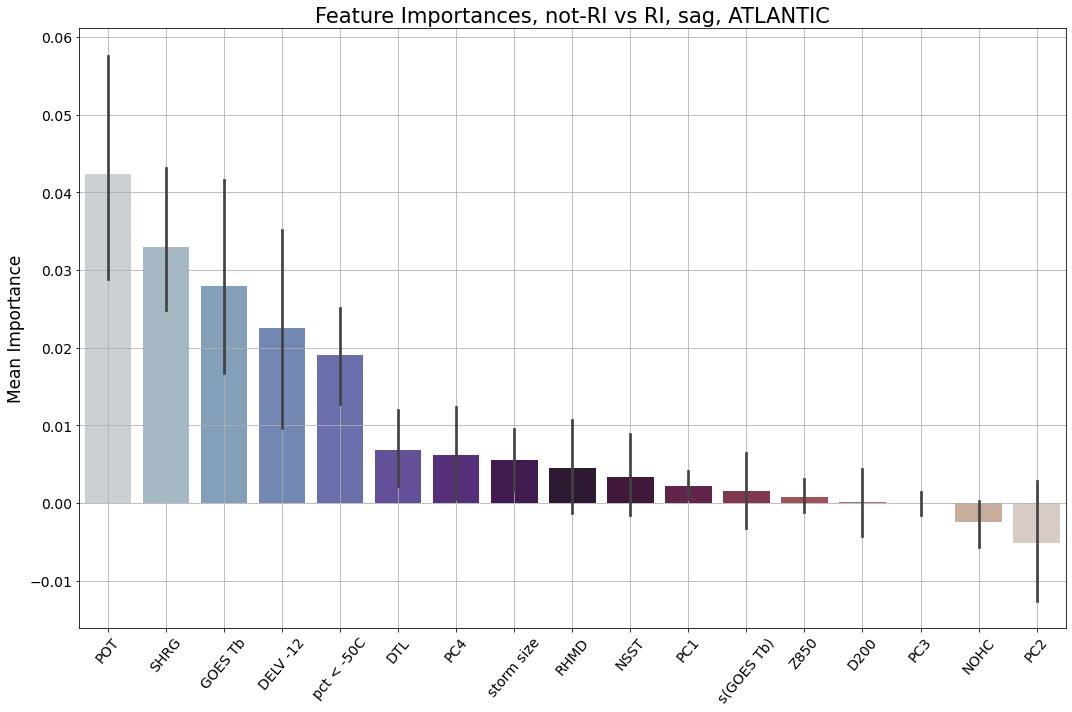

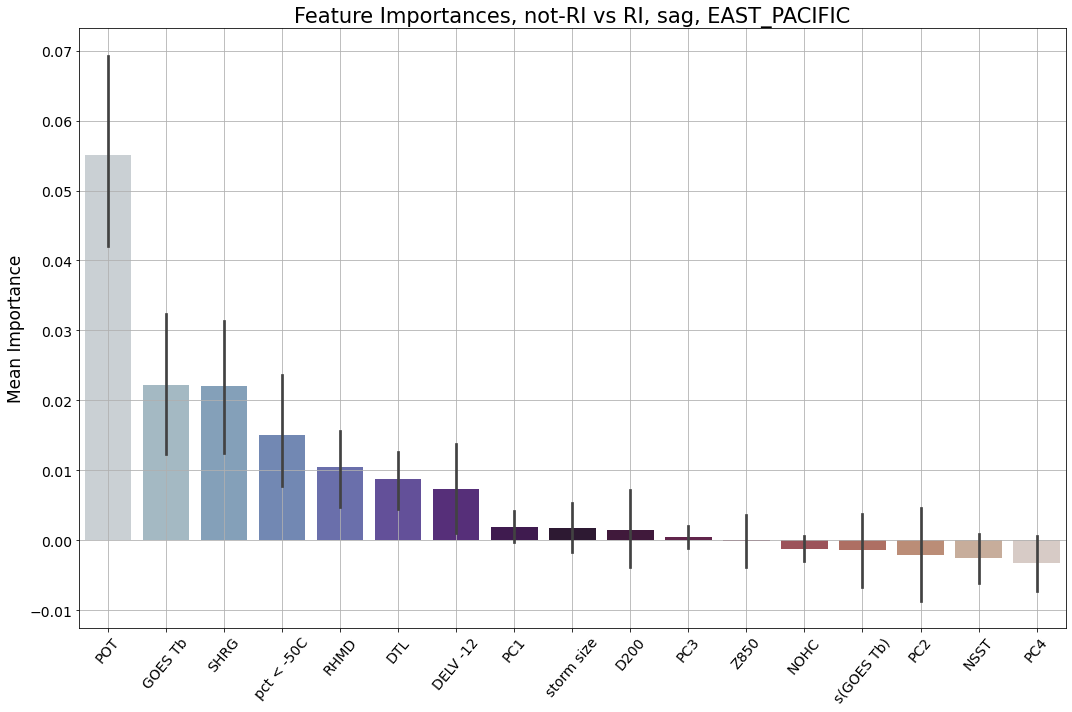

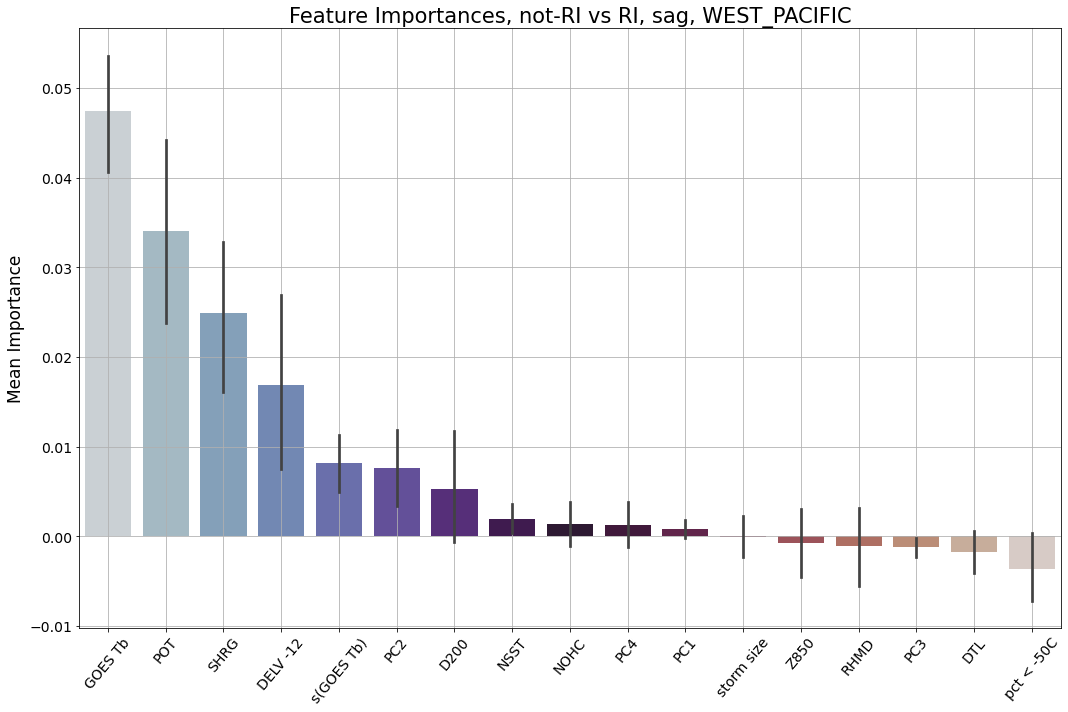

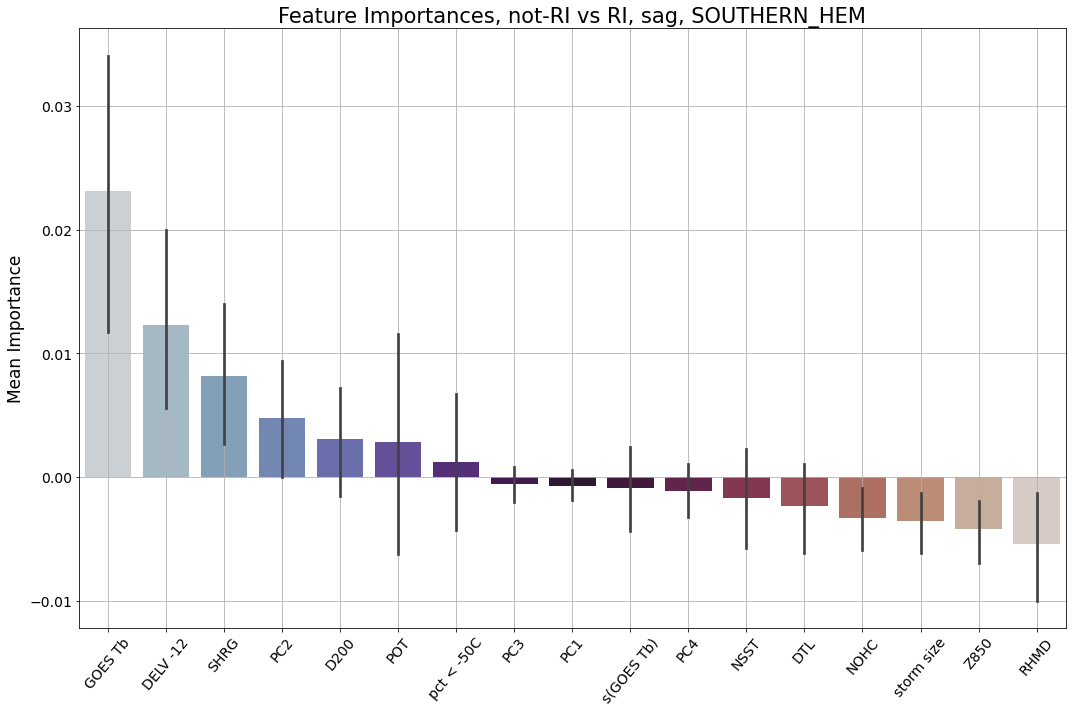

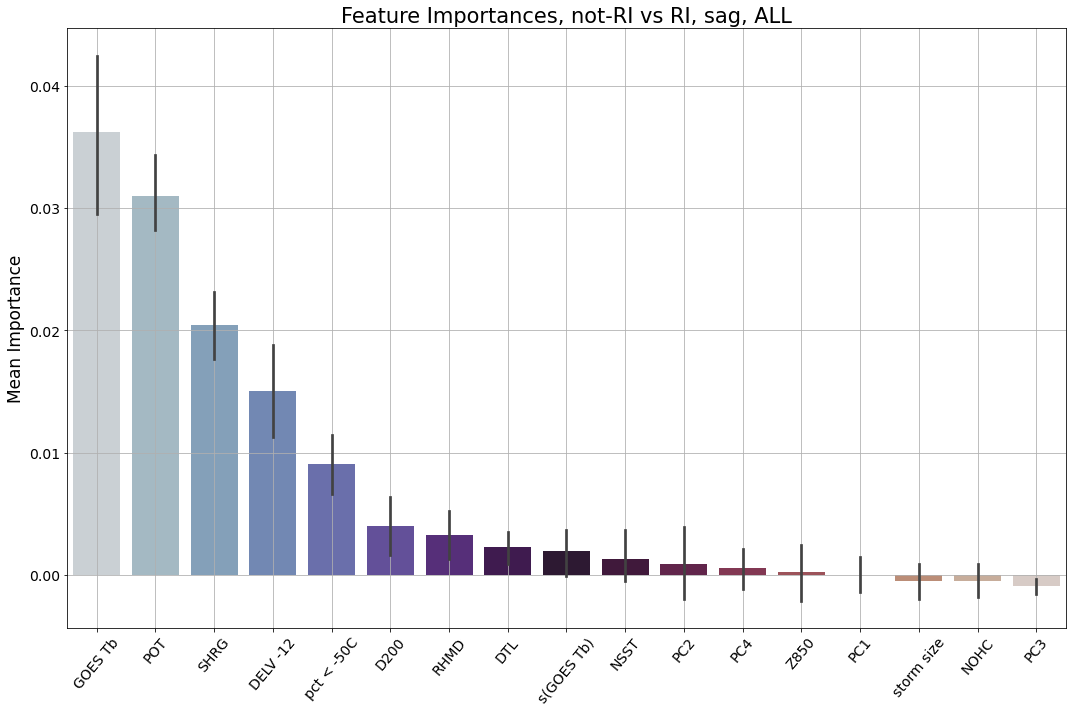

In [27]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, not-RI vs RI, {solver}, {basin}'.format(solver=solver,basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig(save_dir+'figs/Feat_Imp_RI_not_RI_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')


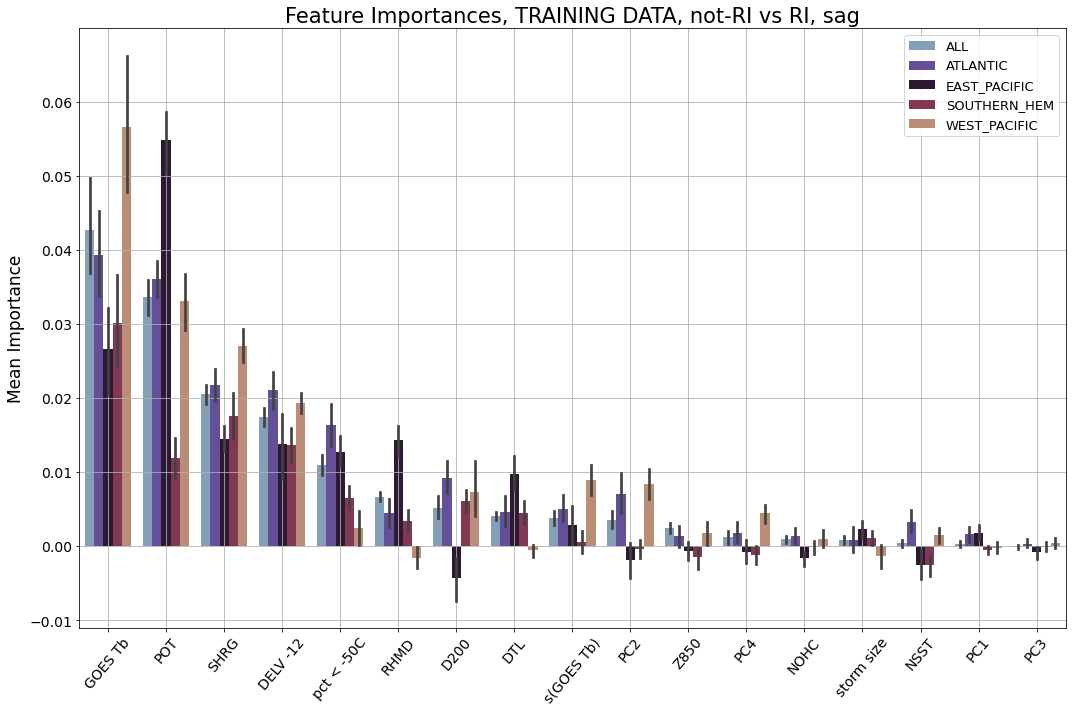

In [28]:
fig7,ax7 = plt.subplots(1,1,figsize=(15,10))
fi_plt = fi_pred_train_ALL.reset_index().sort_values(['BASIN','mean importance'],ascending=False)
fi_plt['mean mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('mean')
fi_plt['max mean'] = fi_plt.groupby(['BASIN','index'])['mean importance'].transform('max')
fi_plt_plt = fi_plt.sort_values(['BASIN','mean mean','max mean'],ascending=[True,False,False])
sns.barplot(data=fi_plt_plt,x='index',y='mean importance',hue='BASIN',
            palette='twilight',ax=ax7)
ax7.set_xticklabels(fi_plt_plt['index'].unique(),fontsize=14,rotation=50)
ax7.set_ylabel('Mean Importance',fontsize=17)
ax7.set_xlabel(None)
ax7.grid()
ax7.tick_params(axis='y',labelsize=14)
ax7.legend(fontsize=13)
ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}'.format(solver=solver),fontsize=21)
fig7.tight_layout()
fig7.savefig(save_dir+'figs/Feat_Imp_TRAIN_RI_not_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Each basin separately

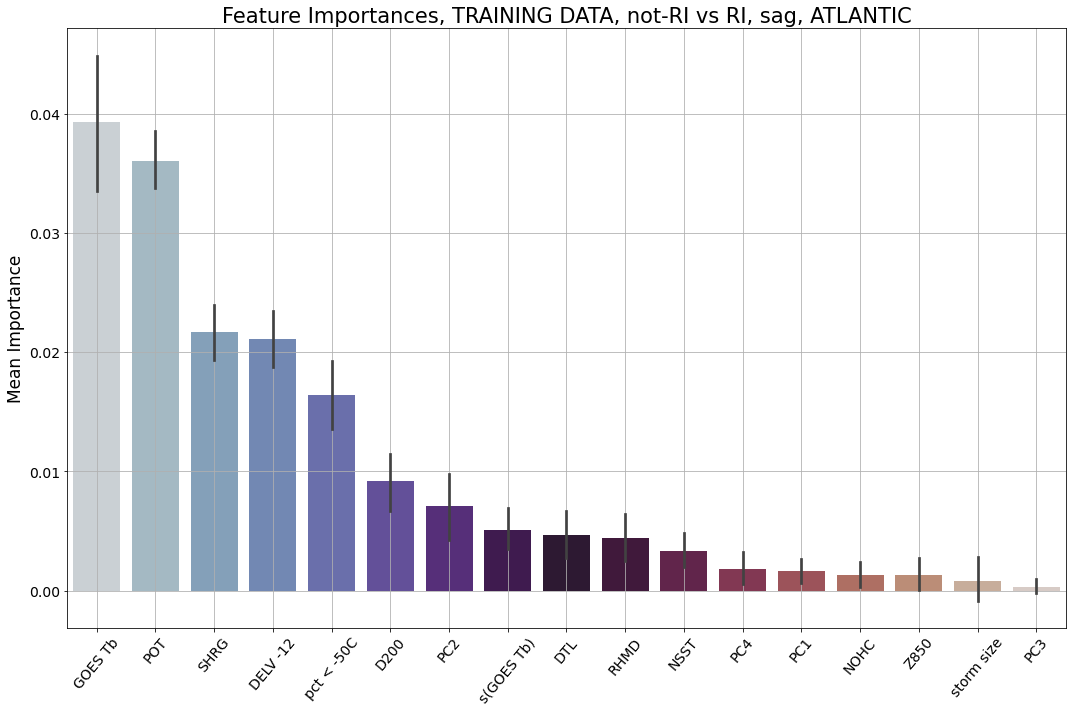

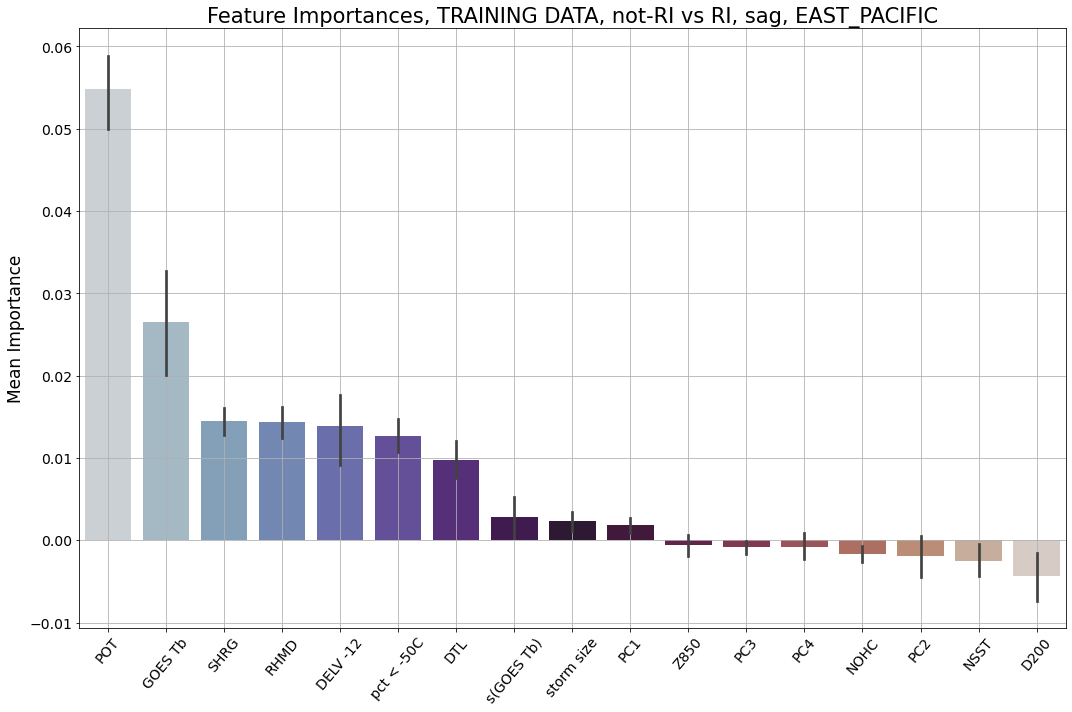

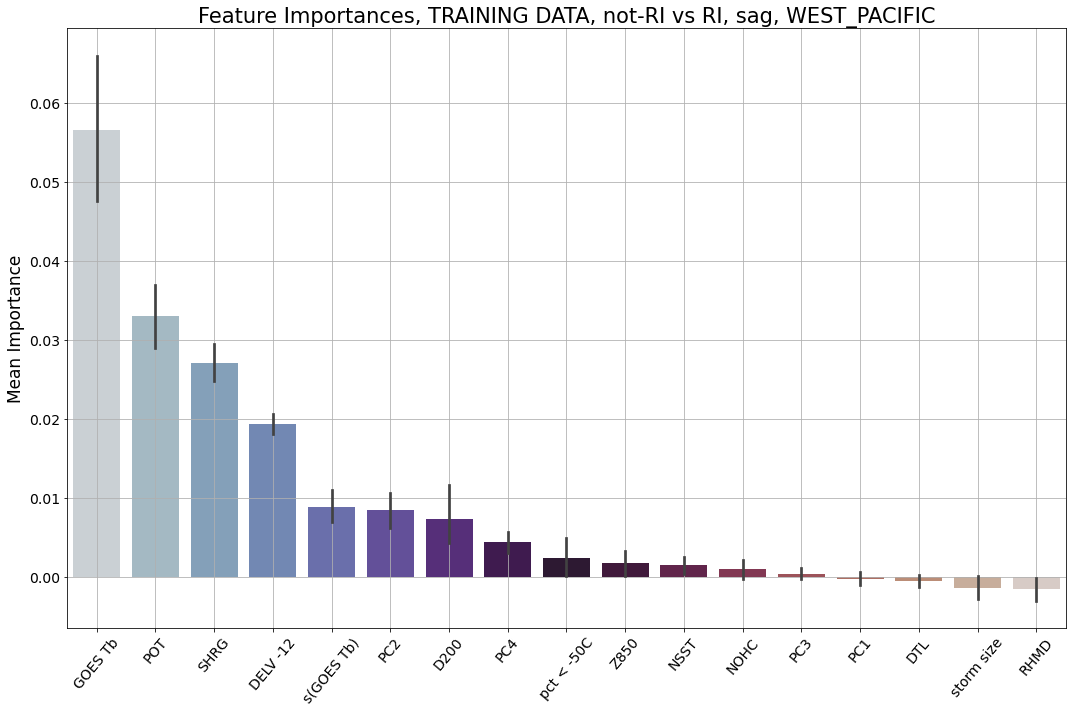

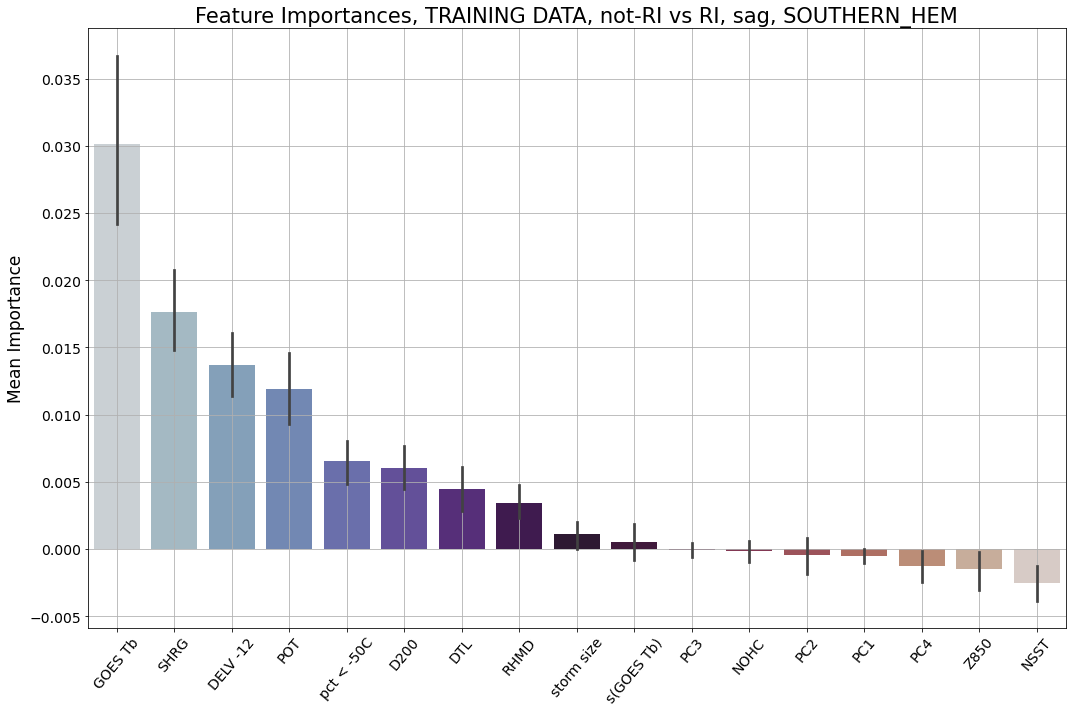

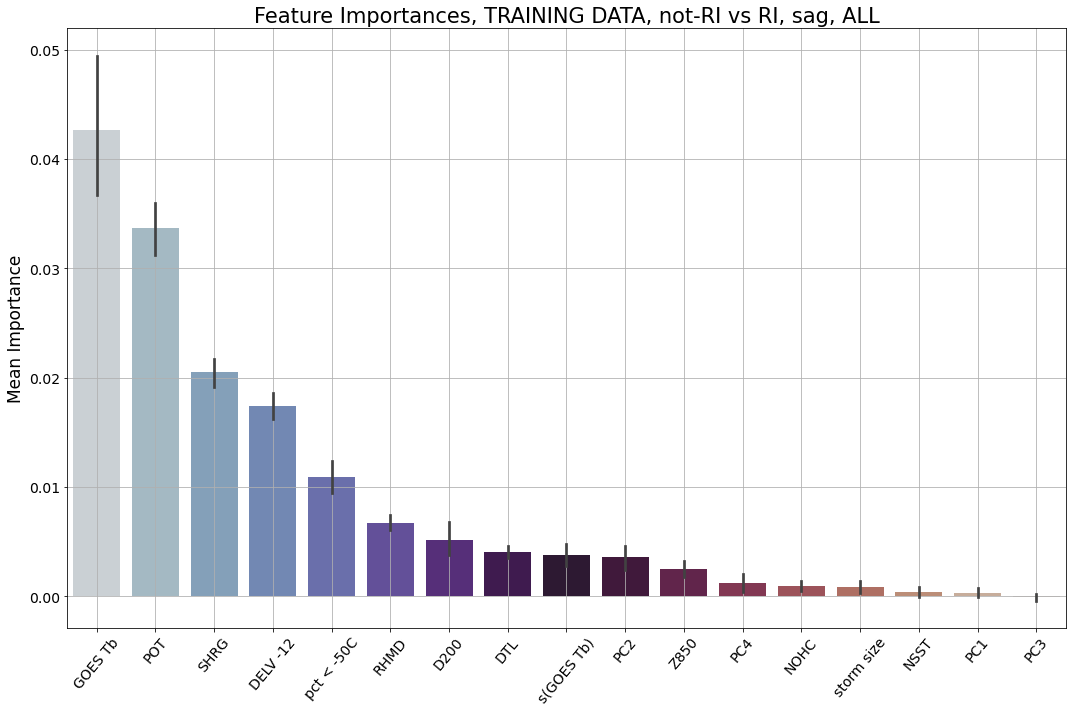

In [29]:
for basin_sel in BASIN_all:
#basin_sel = 'ATLANTIC'
    i_plt = fi_pred_train_ALL.reset_index().set_index(['BASIN']).xs(basin_sel).sort_values(['mean importance'],ascending=False)
    i_plt['mean mean'] = i_plt.groupby(['index'])['mean importance'].transform('mean')
    i_plt['max mean'] = i_plt.groupby(['index'])['mean importance'].transform('max')
    i_plt_plt = i_plt.sort_values(['mean mean','max mean'],ascending=[False,False])
    fig7,ax7 = plt.subplots(1,1,figsize=(15,10))

    sns.barplot(data=i_plt_plt,x='index',y='mean importance',
                palette='twilight',ax=ax7)
    ax7.set_xticklabels(i_plt_plt['index'].unique(),fontsize=14,rotation=50)
    ax7.set_ylabel('Mean Importance',fontsize=17)
    ax7.tick_params(axis='y',labelsize=14)
    ax7.set_xlabel(None)
    ax7.grid()
    #ax7.legend(fontsize=13)
    ax7.set_title('Feature Importances, TRAINING DATA, not-RI vs RI, {solver}, {basin}'.format(solver=solver,basin=basin_sel),fontsize=21)
    fig7.tight_layout()
    fig7.savefig(save_dir+'figs/Feat_Imp_RI_not_RI_TRAINING_{basin_sel}'.format(basin_sel=basin_sel)+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')


In [30]:
fi_pred_ALL.reset_index().sort_values('mean importance',ascending=False).head(20)
cm_ALL.groupby(['Category Names','BASIN','C']).count()

Hits  POD  N_actual  PFOD  FAR  \
Category Names BASIN        C                                       
RI             ALL          0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               ATLANTIC     0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               EAST_PACIFIC 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               SOUTHERN_HEM 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               WEST_PACIFIC 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
not RI         ALL          0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               ATLANTIC     0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               EAST_PACIFIC 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               SOUTHERN_HEM 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   
               WEST_PACIFIC 0.1       9    9         9     9    9   
                            1.0       2    2         2     2    2   
                            10.0      2    2         2     2    2   
                            100.0     2    2         2     2    2   

                                   N_predicted  Misses  Category  \
Category Names BASIN        C                                      
RI             ALL          0.1              9       9         9   
                            1.0              2       2         2   
                            10.0             2       2         2   
                            100.0            2       2         2   
               ATLANTIC     0.1              9       9         9   
                            1.0              2       2         2   
                            10.0             2       2         2   
                            100.0            2       2         2   
               EAST_PACIFIC 0.1              9       9         9   
                            1.0              2       2         2   
                            10.0             2       2         2   
                            100.0            2       2         2   
               SOUTHERN_HEM 0.1              9       9         9   
                            1.0              2       2         2   
                            10.0             2  

##### What do we need for a performance diagram?
* Success ratio
* Probability of detection
* Bias
* Threat score / Critical Success Index 
* Uncertainy for POD and success ratio

1. X/Y axis is in POD / Success ratio space
2. Then we have dashed lines showing bias scores, and solid contours labeling CSI 

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  plt.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = plt.contour(


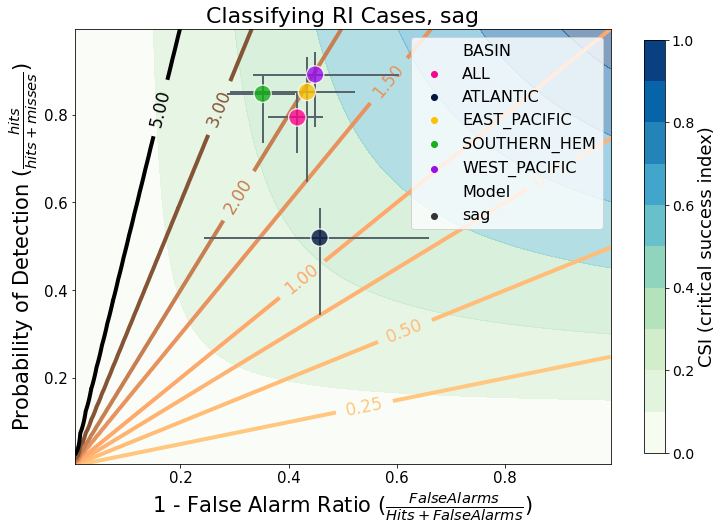

In [31]:
fig12,ax12 = plt.subplots(1,1,figsize=(12,8))
SHIPS_plotting.make_performance_diagram_background(ax12)

#ax12.errorbar(cm_ALL_PD_sel.reset_index()['SR'],cm_ALL_PD_sel.reset_index()['POD'],yerr=cm_ALL_yerr,xerr=cm_ALL_xerr,
 #           linestyle='none',linewidth=2,color='k')
#sns.scatterplot(data=cm_ALL_PD_sel.reset_index(),x='SR',y='POD',hue='BASIN',ax=ax12,palette=sns.set_palette(pal_sel),
  #              s=180,zorder=10)
ax12.set_title('Classifying RI Cases, {solver}'.format(solver=solver),fontsize=22)
SHIPS_plotting.add_model_results(ax12,cm_ALL)
fig12.savefig(save_dir+'figs/Performance_Diagram'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

#### Performance Diagram curves: PoD vs Success Ratio

1. PoD vs Success Ratio curves.  Each fold shown separately, and then averaged across all folds.  Each basin will be separate.
2. AUPD (area under performance diagram) scores. Calculated for each fold and shown as a swarm or box plot, all basins on one plot
3. Max CSI. Calculated for each fold / basin and shown as swarm or box plot, all basins on one plot. 
4. CSI vs Bias.  Calculated for each fold / basin and shown as scatterplot, all basins on one plot. Also show mean across all folds. 


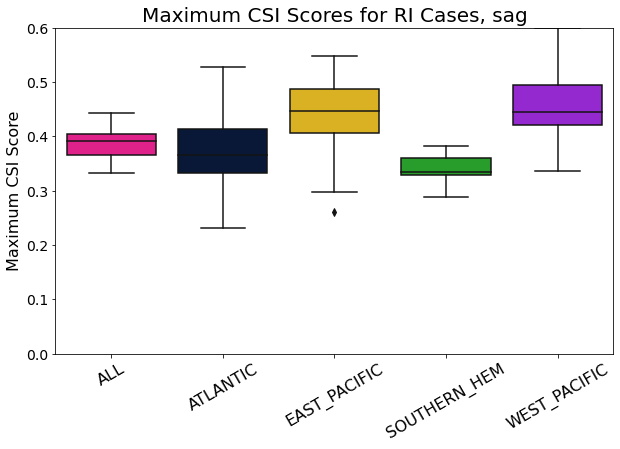

In [32]:
pd_curves = SHIPS_ML_model_funcs.calculate_PD_curves(p_vs_r_ALL)
fig15,ax15 = plt.subplots(1,1,figsize=(10,6))
max_CSI_ind = p_vs_r_ALL.groupby(['BASIN','Fold'])[['CSI','Bias']].agg({'CSI':'max'}).reset_index()
SHIPS_plotting.plot_basic_score_basin(ax15,max_CSI_ind,'CSI',False)
ax15.set_title('Maximum CSI Scores for RI Cases, {solver}'.format(solver=solver),fontsize=20)
ax15.set_ylabel('Maximum CSI Score',fontsize=16)
ax15.set_ylim([0,0.6])
fig15.savefig(save_dir+'figs/Max_CSI_RI_vs_basin'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

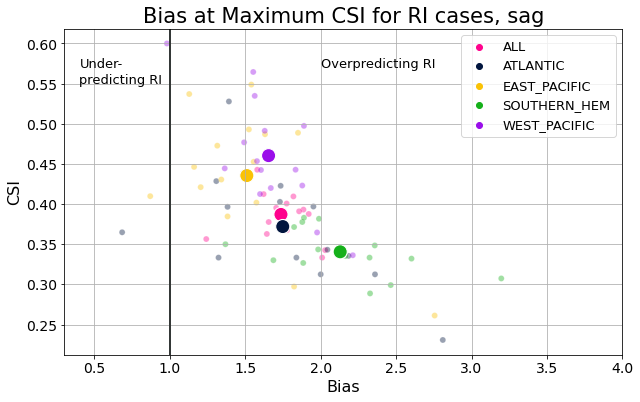

In [33]:
#sns.swarmplot(data=foo2.reset_index(),x='BASIN',y='CSI')
fig30,ax30 = plt.subplots(1,1,figsize=(10,6))
SHIPS_plotting.plot_CSI_vs_bias(p_vs_r_ALL,ax30)
ax30.set_title('Bias at Maximum CSI for RI cases, {solver}'.format(solver=solver),fontsize=21)
fig30.savefig(save_dir+'figs/CSI_vs_bias_RI'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

<AxesSubplot:xlabel='Bias', ylabel='CSI'>

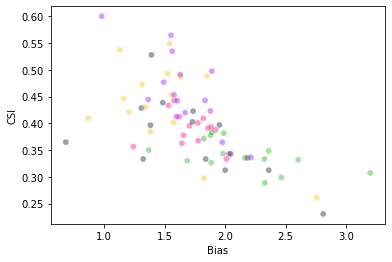

In [34]:
b_c_max = p_vs_r_ALL.sort_values(['CSI'], ascending=[False]).groupby(['BASIN','Model','Fold']).first()
sns.scatterplot(data=b_c_max.reset_index(),x='Bias',y='CSI',hue='BASIN',style='Model',alpha=0.4,legend=False)

##### Area under PD Curve

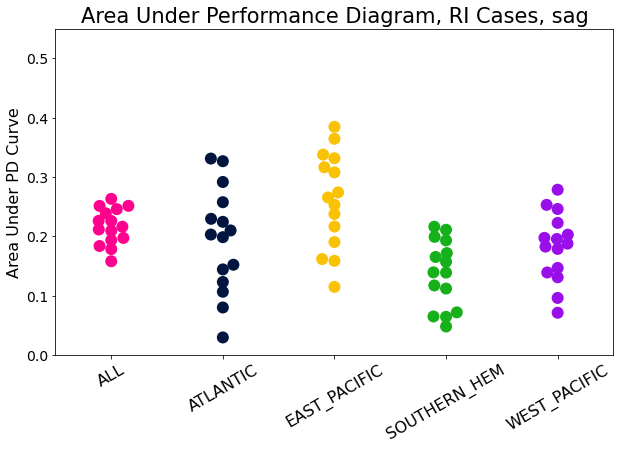

In [35]:
aupd_scores = SHIPS_ML_model_funcs.calc_AUPD(p_vs_r_ALL)
aupd_plt = aupd_scores.reset_index().rename(columns={0:'AUPD'})
fig14,ax14 = plt.subplots(1,1,figsize=(10,6))
SHIPS_plotting.plot_basic_score_basin(ax14,aupd_plt,'AUPD',True)
ax14.set_ylabel('Area Under PD Curve',fontsize=16)
ax14.set_title('Area Under Performance Diagram, RI Cases, {solver}'.format(solver=solver),fontsize=21)
ax14.set_ylim([0,0.55])
fig14.savefig(save_dir+'figs/AUPD_calculation_RI_cases'+save_ext_figs,
            format='png',dpi=250,bbox_inches='tight')

In [36]:
import warnings
warnings.filterwarnings("ignore")

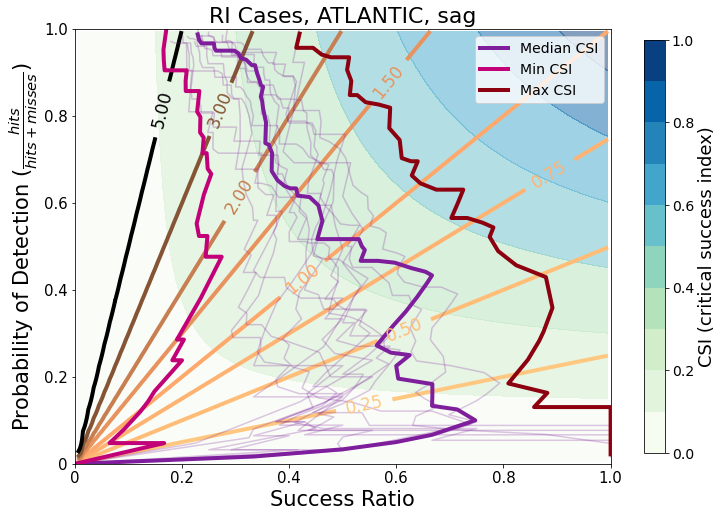

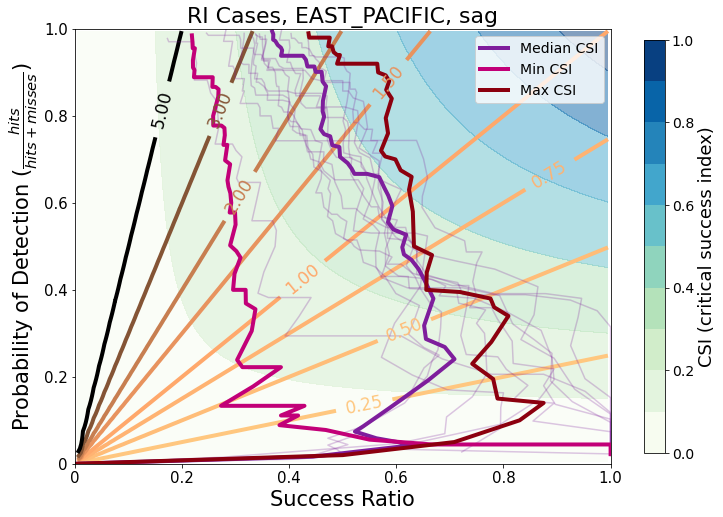

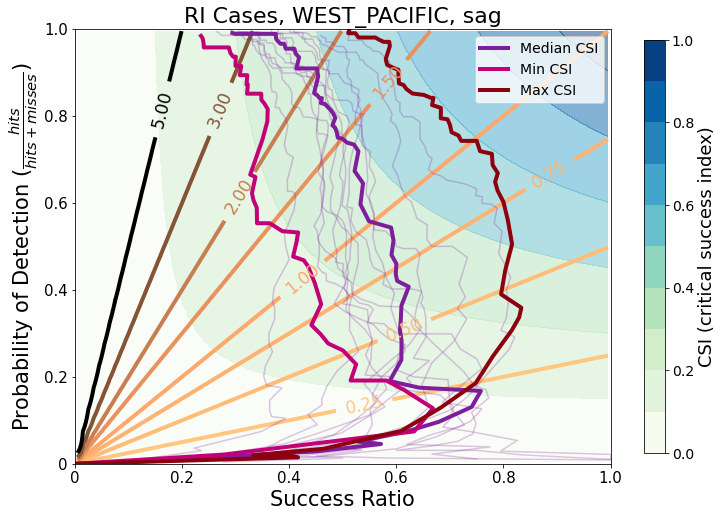

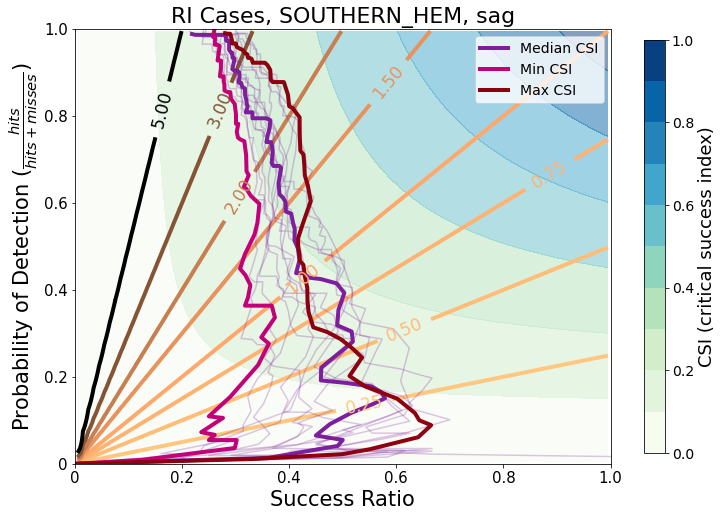

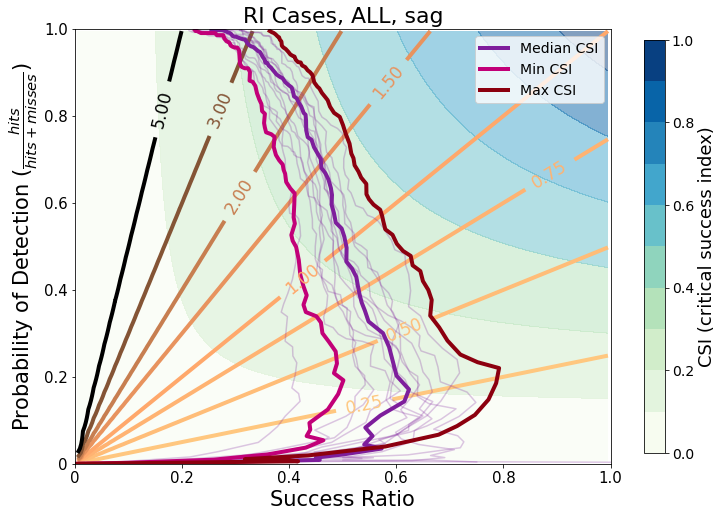

In [37]:
for basin_sel in BASIN_all:
    fig23,ax23 = plt.subplots(1,1,figsize=(12,8))
    SHIPS_plotting.make_performance_diagram_background(ax23)
    SHIPS_plotting.plot_PD_curves(p_vs_r_ALL,ax23,basin_sel)
    ax23.set_title('RI Cases, {basin_sel}, {solver}'.format(basin_sel=basin_sel,solver=solver),fontsize=22)
    f23_save = save_dir+'figs/Performance_Diagram_CURVES_{basin_sel}'.format(basin_sel=basin_sel)
    fig23.savefig(f23_save+save_ext_figs,
                format='png',dpi=250,bbox_inches='tight')